### Install dependencies

In [ ]:
# Environment & installs (run once)
# If using Google Colab, prepend `!` to pip commands. If local, run in venv/conda.
!pip install  nltk spacy transformers datasets accelerate evaluate sentencepiece streamlit
!python -m spacy download en_core_web_sm



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 131.3 kB/s eta 0:01:38
     --------------------------------------- 0.0/12.8 MB 131.3 kB/s eta 0:01:38
     --------------------------------------- 0.0/12.8 MB 164.3 kB/s eta 0:01:18
     --------------------------------------- 0.1/12.8 MB 218.8 kB/s eta 0:00:59
     --------------------------------------- 0.1/12.8 MB 218.8 kB/s eta 0:00:59
     --------------------------------------- 0.1/12.8 MB 218.8 kB/s eta 0:00:59
     --------------------------------------- 0.1/12.8 MB 171.1 kB/s eta 0:01:15
     --------------------------------------- 0.1/12.8 MB 171.1 kB/s eta 0:01:15
     --------------------------------------- 0.1/12.8 MB 211.6 kB/s eta 0:01:00
     --------------------------------------- 0.2/12.8 MB 262.1 k


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing

In [1]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

# ML
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline


# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from datasets import Dataset, DatasetDict

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


C:\Users\Ahmed Dief\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset
make sure you but path of data folder correct

In [2]:
#Load dataset from folders

DATA_DIR = "./Downloads/bbc"  # Path to your BBC folder

texts = []
labels = []

for category in os.listdir(DATA_DIR):
    category_path = os.path.join(DATA_DIR, category)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(category_path, filename)
                with open(file_path, "r", encoding="latin1") as f:
                    content = f.read()
                texts.append(content)
                labels.append(category)

df = pd.DataFrame({"text": texts, "category": labels})
print(f"Loaded {df.shape[0]} articles")
df.head()


Loaded 2225 articles


,text,category
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [4]:
# EDA
print(df['category'].value_counts())
df['text_length'] = df['text'].str.split().apply(len)
df['text_length'].describe()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


count    2225.000000
mean      384.040449
std       238.174497
min        89.000000
25%       246.000000
50%       332.000000
75%       471.000000
max      4432.000000
Name: text_length, dtype: float64

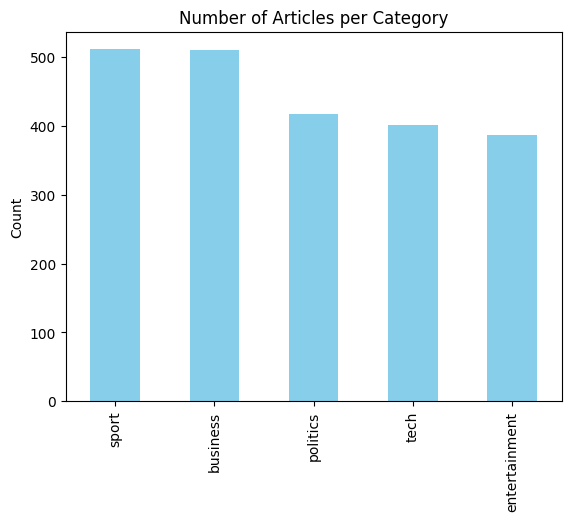

In [6]:
pd.Series(labels).value_counts().plot(kind='bar', color='skyblue')
plt.title("Number of Articles per Category")
plt.ylabel("Count")
plt.show()

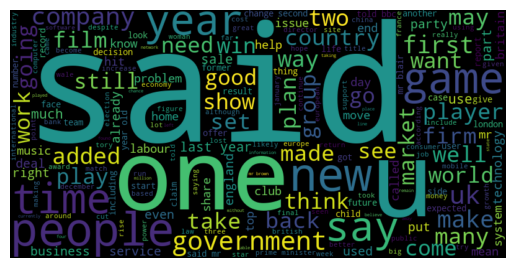

In [7]:
#Word Clouds
text = " ".join(df['text_clean'])
wc = WordCloud(width=800, height=400).generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Preprocessing

In [8]:
# Preprocessing
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

import re
def clean_text(text):
    text = text.lower() #Lowercase
    text = re.sub(r"[^\w\s]", " ", text) #Removes all punctuation marks from the text
    text = re.sub(r"\s+", " ", text).strip() #Removes leading and trailing whitespace
    toks = text.split()
    toks = [t for t in toks if t not in stop_words] #Remove stopword
    toks = [lemmatizer.lemmatize(t) for t in toks]  #Applies lemmatization to each remaining word
    return " ".join(toks)

df['text_clean'] = df['text'].apply(clean_text)
df[['text', 'text_clean']].head()

,text,text_clean
0,Ad sales boost Time Warner profit\n\nQuarterly...,ad sale boost time warner profit quarterly pro...
1,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar hit highes...
2,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer face loan claim owner embattl...
3,High fuel prices hit BA's profits\n\nBritish A...,high fuel price hit ba profit british airway b...
4,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lift domecq share uk drin...


In [10]:
# Train/test split
train_df, test_df = train_test_split(
    df[['text_clean','category']],
    test_size=0.2,
    stratify=df['category'],
    random_state=SEED
)

### Baseline Model 

In [11]:
#cross-validation
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000))
])

params = {
    'tfidf__max_features': [3000, 5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__max_iter': [200, 300, 500]
}

grid = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(train_df['text_clean'], train_df['category'])
print("Best max_features:", grid.best_params_['tfidf__max_features'])
print("Best ngram_range:", grid.best_params_['tfidf__ngram_range'])
print("Best max_iteration:", grid.best_params_['clf__max_iter'])


Best max_features: 5000
Best ngram_range: (1, 2)
Best max_iteration: 200


In [12]:
#show how many vocabulary
vocab_size = len(CountVectorizer().fit(train_df['text_clean']).vocabulary_)
print("Full vocabulary size:", vocab_size)


Full vocabulary size: 23901


Why use 5,000 not 23,901 ?

Rare words add noise
* Many words in the full vocab appear only once or twice, often as names, numbers, or typos.
* These don’t help classification much but blow up the feature space, making the model harder to train.

TF-IDF already down-weights common terms
* Keeping only the most informative features avoids wasting computation on extremely rare ones.


In [13]:
# Baseline model (TF-IDF + LogisticRegression)
# max_features → Limits the vocabulary to the top 5,000 most frequent terms (to prevent excessive memory usage)
#ngram_range → Extracts unigrams (single words) and bigrams (pairs of consecutive words)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) 
# max_itr → Increases the maximum number of iterations for convergence
clf = LogisticRegression(max_iter=200, random_state=SEED)

baseline_pipe = Pipeline([
    ("tfidf", tfidf),
    ("clf", clf)
])

baseline_pipe.fit(train_df['text_clean'], train_df['category']) #Convert text to TF-IDF vectors


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


### Evaluate baseline

In [15]:
# Evaluate baseline, with accuracy, precision, recall, and confusion matrix.
preds = baseline_pipe.predict(test_df['text_clean'])
acc = accuracy_score(test_df['category'], preds)
prec, rec, f1, _ = precision_recall_fscore_support(test_df['category'], preds, average='weighted')
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print(classification_report(test_df['category'], preds))

Accuracy: 0.9888, Precision: 0.9889, Recall: 0.9888, F1: 0.9887
               precision    recall  f1-score   support

     business       1.00      0.97      0.99       102
entertainment       0.99      1.00      0.99        77
     politics       0.99      0.98      0.98        84
        sport       0.99      1.00      1.00       102
         tech       0.98      1.00      0.99        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445



In [16]:
# Save baseline
import joblib
joblib.dump(baseline_pipe, "baseline_tfidf_logreg.joblib")

['baseline_tfidf_logreg.joblib']

In [18]:
# Prepare data for DistilBERT
label_list = sorted(df['category'].unique())
label_to_id = {l:i for i,l in enumerate(label_list)}

def df_to_hf(df):
    return Dataset.from_pandas(df.rename(columns={'text_clean':'text'}))

train_hf = df_to_hf(train_df)
test_hf = df_to_hf(test_df)

train_hf = train_hf.map(lambda e: {"label": label_to_id[e["category"]]})
test_hf = test_hf.map(lambda e: {"label": label_to_id[e["category"]]})

dataset = DatasetDict({"train": train_hf, "test": test_hf})

Map: 100%|██████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 3241.31 examples/s]


In [19]:
# Tokenizer & model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list))

def preprocess(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

tokenized = dataset.map(preprocess, batched=True)
tokenized = tokenized.remove_columns(["text","category"])
tokenized.set_format("torch")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1102.64 examples/s]


In [20]:
#Train DistilBERT
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

training_args = TrainingArguments(
    output_dir="distilbert-bbc",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=2,   
    per_device_eval_batch_size=2,
    num_train_epochs=1,              
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=50,
    dataloader_num_workers=2,        
    report_to="none"                 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\Ahmed Dief\AppData\Local\Temp\ipykernel_10796\318927344.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\Ahmed Dief\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.127100,0.112818,0.982022,0.982251,0.982022,0.981926


TrainOutput(global_step=890, training_loss=0.24684929044059153, metrics={'train_runtime': 1757.4348, 'train_samples_per_second': 1.013, 'train_steps_per_second': 0.506, 'total_flos': 117902292326400.0, 'train_loss': 0.24684929044059153, 'epoch': 1.0})

### Results comparison
1. Baseline Model → TF-IDF + Logistic Regression (your GridSearchCV-optimized one)
2. NLP Upgrade → DistilBERT fine-tuned on your BBC dataset
| Model                  | Accuracy | Precision | Recall | F1-score |
| ---------------------- | -------- | --------- | ------ | -------- |
| TF-IDF + Logistic Reg. | 0.9888     | 0.9889      | 0.9888   | 0.9887     |
| DistilBERT             | 0.9820     | 0.9822     | 0.9820   | 0.9819     |


In [22]:
# Save DistilBERT
trainer.save_model("distilbert_bbc_saved")
tokenizer.save_pretrained("distilbert_bbc_saved")

('distilbert_bbc_saved\\tokenizer_config.json',
 'distilbert_bbc_saved\\special_tokens_map.json',
 'distilbert_bbc_saved\\vocab.txt',
 'distilbert_bbc_saved\\added_tokens.json',
 'distilbert_bbc_saved\\tokenizer.json')

### Ethics & Risks
- **Potential bias in training data**
  - The BBC dataset presents articles selected and labeled by humans; categories may underrepresent minority topics, editorial choices may bias language usage and framing.
- **Risks of misclassification**
  - Misclassifying political articles as business (or vice versa) may mislead downstream applications (analytics, automated routing) and harm trust.
  - False confidence: model may output high confidence for wrong labels.
- **Mitigations**
  - Use calibrated probabilities, thresholding and human-in-the-loop for uncertain predictions.
  - Monitor real-world performance, gather additional labeled examples from deployment domain, and retrain periodically.
  - Provide clear UI warnings and "uncertain" or "unknown" flags for low-confidence predictions.
